<a href="https://www.kaggle.com/code/ibrahimnibrahim/simple-vs-comminuted-fractures?scriptVersionId=244283676" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

2025-06-07 21:53:00.947569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749333181.141602      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749333181.198386      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
Augmented='/kaggle/input/simple-vs-comminuted-fractures-x-ray-data/Bone Fracture X-ray Dataset Simple vs. Comminuted Fractures/Bone Fracture X-ray Dataset Simple vs. Comminuted Fractures/Bone Fracture/Bone Fracture/Augmented'

Orginal='/kaggle/input/simple-vs-comminuted-fractures-x-ray-data/Bone Fracture X-ray Dataset Simple vs. Comminuted Fractures/Bone Fracture X-ray Dataset Simple vs. Comminuted Fractures/Bone Fracture/Bone Fracture/Orginal'

In [3]:
batch_size = 64
img_height = 224
img_width = 224

train,valid = image_dataset_from_directory(
    Orginal,
    labels='inferred',
    label_mode='binary',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='both'
)

Found 2384 files belonging to 2 classes.
Using 1908 files for training.
Using 476 files for validation.


I0000 00:00:1749333199.640349      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [4]:
train_ds = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = valid.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2), 
    tf.keras.layers.RandomZoom(0.2), 
])


inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = base_model(x, training=True)  # Pass inputs through the base model
x = tf.keras.layers.Flatten()(x)  
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Fully connected layer
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Output layer

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [7]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      64,226,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,276,900 (260.46 MB)

 Trainable params: 68,234,877 (260.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  
    patience=10,          
    min_delta=0.001,     
    restore_best_weights=True  
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.1,         
    patience=5,         
    min_lr=1e-7,      
    mode='max',      
    verbose=1          
)

In [9]:
history=model.fit(train_ds, epochs=100,validation_data=val_ds,callbacks=[early_stopping,reduce_lr])

Epoch 1/100


E0000 00:00:1749333263.114362      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1749333276.632909      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


30/30 ━━━━━━━━━━━━━━━━━━━━ 94s 751ms/step - accuracy: 0.6127 - loss: 22.6028 - val_accuracy: 0.6639 - val_loss: 18.9944 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 517ms/step - accuracy: 0.7146 - loss: 15.0051 - val_accuracy: 0.7605 - val_loss: 8.2838 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 520ms/step - accuracy: 0.8124 - loss: 6.5430 - val_accuracy: 0.8151 - val_loss: 4.0004 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 517ms/step - accuracy: 0.8637 - loss: 3.4692 - val_accuracy: 0.8403 - val_loss: 2.9284 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 517ms/step - accuracy: 0.9021 - loss: 2.7098 - val_accuracy: 0.8950 - val_loss: 3.1025 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 515ms/step - accuracy: 0.9008 - loss: 3.0316 - val_accuracy: 0.9118 - val_loss: 3.0574 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 500ms/step - accuracy: 0.9288 - loss: 2.86

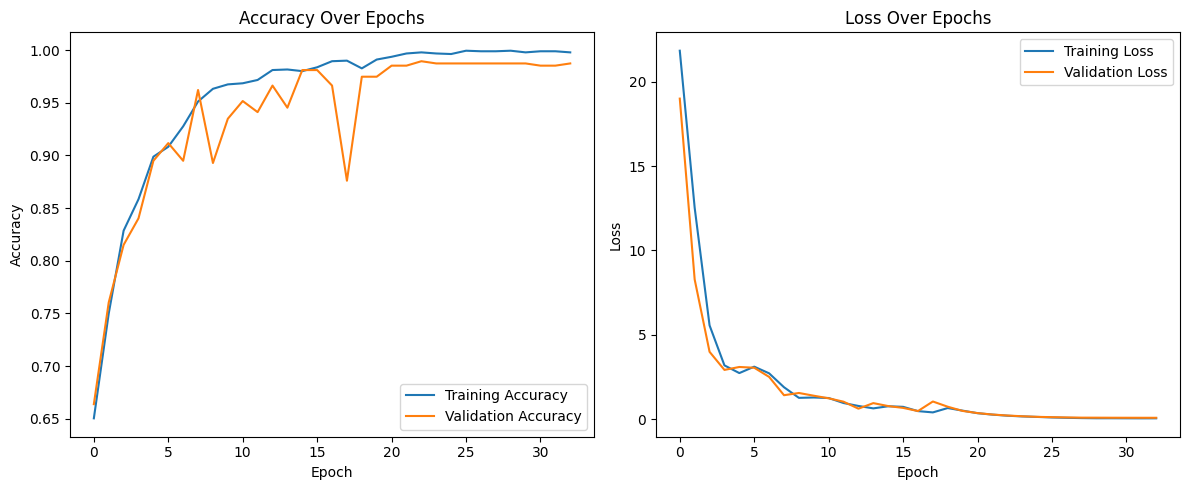

In [10]:
# Plotting
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()  # Prevent label overlap
plt.show()

In [11]:
y_pred = model.predict(val_ds)
y_pred = (y_pred > 0.5).astype(int).flatten()

# Get true labels
y_true = []
for images, labels in val_ds:
  y_true.extend(labels.numpy())

y_true = np.array(y_true)

# Generate classification report
print(classification_report(y_true, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 641ms/step
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       236
         1.0       1.00      0.98      0.99       240

    accuracy                           0.99       476
   macro avg       0.99      0.99      0.99       476
weighted avg       0.99      0.99      0.99       476



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


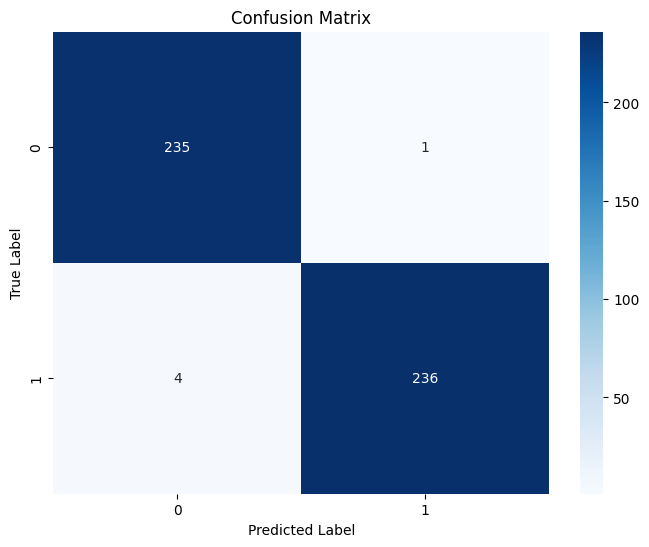

In [12]:
predictions = model.predict(val_ds)
predicted_classes = (predictions > 0.5).astype(int)

true_labels = []
for images, labels in val_ds:
    true_labels.extend(labels.numpy())

cm = confusion_matrix(true_labels, predicted_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()